# [CSC8101] Big Data Analytics - 2022 Spark Coursework

#### Student ID: 220624059

## Coursework overview

### Inputs

- **NYC Taxi Trips dataset** - list of recorded taxi trips, each with several characteristics, namely: distance, number of passengers, origin zone, destination zone and trip cost (total amount charged to customer).
- **NYC Zones dataset** - list of zones wherein trips can originate/terminate.

### Tasks

1. Data cleaning
  1. Remove "0 distance" and 'no passengers' records.
  2. Remove outlier records. 
2. Add new columns
  1. Join with zones dataset
  2. Compute the unit profitability of each trip
3. Zone summarisation and ranking
  1. Summarise trip data per zone
  2. Obtain the top 10 ranks according to:
    1. The total trip volume
    2. Their average profitabilitiy
    3. The total passenger volume
4. Record the total and task-specific execution times for each dataset size and format.

### How to

###### Code structure and implementation

- You must implement your solution to each task in the provided function code skeleton.
- The task-specific functions are combined together to form the full pipeline code, executed last (do not modify this code).
- Before implementing the specified function skeleton, you should develop and test your solution on separate code cells (create and destroy cells as needed).

###### Development

- Develop an initial working solution for the 'S' dataset and only then optimise it for larger dataset sizes.
- To perform vectorised operations on a DataFrame:
  - use the API docs to look for existing vectorised functions in: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql.html#functions
  - if a customised function is required (e.g. to add a new column based on a linear combination of other columns), implement your own User Defined Function (UDF). See:  https://spark.apache.org/docs/latest/sql-ref-functions-udf-scalar.html
- Use only the `pyspark.sql` API - documentation link below - (note that searching through the docs returns results from the `pyspark.sql` API together with the `pyspark.pandas` API):
  - https://spark.apache.org/docs/3.2.0/api/python/reference/pyspark.sql.html
- Periodically download your notebook to your computer as backup and safety measure against accidental file deletion.
 
###### Execution time measurement

- Execution time is calculated and returned by the Spark Engine and shown in the output region of the cell.
- To measure the execution time of a task you must perform a `collect` or similar operation (e.g. `take`) on the returned DataFrame.

## Task 0 - Read data

The code below is ready to run. **Do not modify this code**. It does the following:

- Reads the 'zones' dataset into variable 'zone_names'
- Defines the `init_trips` function that allows you to read the 'trips' dataset (from the DBFS FileStore) given the dataset size ('S' to 'XXL') and format ('parquet' or 'delta') as function arguments
- Defines the `pipeline` function, called in Task 4 to measure the execution time of the entire data processing pipeline
- Shows you how to call the `init_trips` function and display dataset characteristics (number of rows, schema)

In [ ]:
## global imports
import pyspark.sql as ps
import pyspark.sql.functions as pf
from pyspark.sql.functions import percentile_approx, avg, abs
import pandas as pd

# Load zone names dataset - (much faster to read small file from git than dbfs)
zones_file_url = 'https://raw.githubusercontent.com/NewcastleComputingScience/csc8101-coursework/main/02-assignment-spark/taxi_zone_names.csv'
zone_names = spark.createDataFrame(pd.read_csv(zones_file_url))

# Function to load trips dataset by selected dataset size
def init_trips(size = 'S', data_format = "parquet", taxi_folder = "/FileStore/tables/taxi"):     
    
    files = {
        'S'  : ['2021_07'],
        'M'  : ['2021'],
        'L'  : ['2020_21'],
        'XL' : ['1_6_2019', '7_12_2019'],
        'XXL': ['1_6_2019', '7_12_2019', '2020_21']
    }
    
    # validate input dataset size
    if size not in files.keys():
        print("Invalid input dataset size. Must be one of {}".format(list(files.keys())))
        return None               
    
    if data_format == "parquet":
        filenames = list(map(lambda s: f'{taxi_folder}/parquet/tripdata_{s}.parquet', files[size]))
        trips_df = spark.read.parquet(filenames[0])
        
        for name in filenames[1:]:
            trips_df = trips_df.union(spark.read.parquet(name))
            
    elif data_format == "delta":
        filenames = f"{taxi_folder}/delta/taxi-{size}-delta/"
        trips_df = spark.read.format("delta").load(filenames)
    
    else:
        print("Invalid data format. Must be one of {}".format(['parquet', 'delta']))
        return None
        
    print(
    """
    Trips dataset loaded!
    ---
      Size: {s}
      Format: {f}
      Tables loaded: {ds}
      Number of trips (dataset rows): {tc:,}
    """.format(s = size, f = data_format, ds = filenames, tc = trips_df.count()))
    
    return trips_df

# helper function to print dataset row count
def print_count(df):
    print("Row count: {t:,}".format(t = df.count()))

def pipeline(trips_df, with_task_12 = False, zones_df = zone_names):
    # Do not edit
    #---

    ## Task 1.1
    _trips_11 = t11_remove_zeros(trips_df)

    ## Task 1.2
    if with_task_12:
        _trips_12 = t12_remove_outliers(_trips_11)
    else:
        _trips_12 = _trips_11

    ## Task 2.1
    _trips_21 = t21_join_zones(_trips_12, zones_df = zone_names)

    ## Task 2.2
    _trips_22 = t22_calc_profit(_trips_21)

    ## Task 3.1
    _graph = t31_summarise_trips(_trips_22)

    ## Task 3.2
    _zones = t32_summarise_zones_pairs(_graph)

    _top10_trips     = t32_top10_trips(_zones)
    _top10_profit    = t32_top10_profit(_zones)
    _top10_passenger = t32_top10_passenger(_zones)
    
    return([_top10_trips, _top10_profit, _top10_passenger])

In [ ]:
# CHANGE the value of argument 'size' to record the pipeline execution times for increasing dataset sizes
SIZE = 'XL'
DATA_FORMAT = 'delta'

# Load trips dataset
trips = init_trips(SIZE, DATA_FORMAT)

# uncomment line only for small datasets
# trips.take(1)


    Trips dataset loaded!
    ---
      Size: XL
      Format: delta
      Tables loaded: /FileStore/tables/taxi/delta/taxi-XL-delta/
      Number of trips (dataset rows): 90,443,069
    


In [ ]:
print_count(trips)

Row count: 90,443,069


In [ ]:
# dataset schemas
trips.printSchema()

root
 |-- index: long (nullable = true)
 |-- VendorID: double (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- cab_type: string (nullable = true)
 |-- lpep_pickup_datetime: string (nullable = true)
 |-- lpep_dropoff_datetime: string (nullable = true)
 |--

In [ ]:
display(trips[['PULocationID', 'DOLocationID', 'trip_distance', 'passenger_count', 'total_amount']].take(5))

PULocationID,DOLocationID,trip_distance,passenger_count,total_amount
151,239,1.5,1.0,9.95
239,246,2.6,1.0,16.3
236,236,0.0,3.0,5.8
193,193,0.0,5.0,7.55
193,193,0.0,5.0,55.55


##### Columns Understanding:
1. <b>PULocationID:</b> Pickup Location ID
2. <b>DOLocationID:</b> Drop Location ID
3. <b>trip_distance:</b> Distance travelled in trip journey
4. <b>passenger_count:</b> Passenger count during trip journey
5. <b>total_amount:</b> Total amount for trip journey

In [ ]:
zone_names.printSchema()

root
 |-- LocationID: long (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



In [ ]:
display(zone_names.take(5))

LocationID,Borough,Zone,service_zone
1,EWR,Newark Airport,EWR
2,Queens,Jamaica Bay,Boro Zone
3,Bronx,Allerton/Pelham Gardens,Boro Zone
4,Manhattan,Alphabet City,Yellow Zone
5,Staten Island,Arden Heights,Boro Zone


## Task 1 - Filter rows

**Input:** trips dataset

### Task 1.1 - Remove "0 distance" and 'no passengers' records

Remove dataset rows that represent invalid trips:

- Trips where `trip_distance == 0` (no distance travelled)
- Trips where `passenger_count == 0` and `total_amount == 0` (we want to retain records where `total_amount` > 0 - these may be significant as the taxi may have carried some parcel, for example)

Altogether, a record is removed if it satisfies the following conditions:

`trip_distance == 0` or `(passenger_count == 0` and `total_amount == 0)`.

**Recommended:** Select only the relevant dataset columns for this and subsequent tasks: `['PULocationID', 'DOLocationID', 'trip_distance', 'passenger_count', 'total_amount')]`

### Task 1.2 - Remove outliers using the modified z-score

Despite having removed spurious "zero passengers" trips in task 1.1, columns `total_amount` and `trip_distance` contain additional outlier values that must be identified and removed.

To identify and remove outliers, you will use the modified [z-score](https://en.wikipedia.org/wiki/Standard_score) method.
The modified z-score uses the median and [Median Absolute Deviation](https://en.wikipedia.org/wiki/Median_absolute_deviation) (MAD), instead of the mean and standard deviation, to determine how far an observation (indexed by i) is from the mean:

$$z_i = \frac{x_i - \mathit{median}(\mathbf{x})}{\mathbf{MAD}},$$

where x represents the input vector, xi is an element of x and zi is its corresponding z-score. In turn, the MAD formula is:

$$\mathbf{MAD} = 1.483 * \mathit{median}(\big\lvert x_i - \mathit{median}(\mathbf{x})\big\rvert).$$

Observations with **high** (absolute) z-score are considered outlier observations. A score is considered **high** if its __absolute z-score__ is larger than a threshold T = 3.5:

$$\big\lvert z_i \big\rvert > 3.5.$$

where T represents the number of unit standard deviations beyond which a score is considered an outlier ([wiki](https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule)).

This process is repeated twice, once for each of the columns `total_amount` and `trip_distance` (in any order).

**Important:** Use the surrogate function [`percentile_approx`](https://spark.apache.org/docs/3.2.0/api/python/reference/api/pyspark.sql.functions.percentile_approx.html?highlight=percentile#pyspark.sql.functions.percentile_approx) to estimate the median (calculating the median values for a column is expensive as it cannot be parallelised efficiently).

In [ ]:
# develop your solution here (create/destroy cells as needed) and then implement it in the functions below

#### Solution for Task 1.1
- Eliminating dataset rows that having invalid trips i.e. trip distance travelled = 0 and number of passengers = 0 or total amount less than or equal to 0

In [ ]:
# Your solution implementation to task 1.1 goes HERE
def t11_remove_zeros(df):
    ''' Function Removes invalid trips for condition where 
    trip_distance = 0 and number of passengers = 0 or total amount <= 0 '''
    
    dataframe = df.filter(
        ~((pf.col("trip_distance") == 0) | ((pf.col("passenger_count") == 0) & (pf.col("total_amount") <= 0))
    )).select(
        'PULocationID', 'DOLocationID', 'trip_distance', 'passenger_count', 'total_amount'
    )
    
    return dataframe

In [ ]:
# execute task 1.1
# Initiate function for task 1.1 operation
trips_11 = t11_remove_zeros(trips)

# Print count of records
print_count(trips_11)

# Display top 10 records
display(trips_11.take(10))

Row count: 89,563,643


PULocationID,DOLocationID,trip_distance,passenger_count,total_amount
151,239,1.5,1.0,9.95
239,246,2.6,1.0,16.3
163,229,1.3,1.0,9.05
229,7,3.7,1.0,18.5
141,234,2.1,2.0,13.0
246,162,2.8,2.0,19.55
238,151,0.7,1.0,8.5
163,25,8.7,1.0,42.95
224,25,6.3,1.0,28.5
141,234,2.7,1.0,15.3


##### Observations: 
1. As per the above, we can notice that <b>total trip</b> count of <b>Size-"XL"</b> in <b>delta</b> format is <b>90,443,069</b>.
2. After applying the filter for the trips dataset, number of trips slightly reduced to <b>89,563,643</b> with reduction of almost <b>0.97%</b>.
3. Despite applying filters, the <b>negative total amount</b> was still present in the dataframe.

#### Solution for Task 1.2
- Eliminating ouliners readings from table using modified z score of columns total amount and trip distance.

In [ ]:
def t12_remove_outliers(df):
    ''' Function removes outliners records using modified z score of total amount and trip distance.
    Modified z score is calculated using median and Mean Absolute Deviation (MAD) value of column records'''
    
    # Variable 'tripDistMedian' and 'totalAmtMedian' consist median value of column trip_distance and total_amount respectively
    tripDistMedian = df.selectExpr("percentile_approx(trip_distance, 0.5)").collect()[0][0]
    totalAmtMedian = df.selectExpr("percentile_approx(total_amount, 0.5)").collect()[0][0]
    
    # Variable 'tripDistMAD' and 'totalAmtMAD' consist MAD value of column trip_distance and total_amount respectively
    tripDistanceMAD = df.select(1.483 * avg(abs(pf.col("trip_distance") - tripDistMedian))).collect()[0][0]
    totalAmtMAD = df.select(1.483 * avg(abs(pf.col("total_amount") - totalAmtMedian))).collect()[0][0]
    
    # Column 'z_value_trip_distance' and 'z_value_totalamount' is added in dataframe having modified z value for each row.
    df = df.select(pf.col("*"), ((pf.col("trip_distance") - tripDistMedian) / tripDistanceMAD).alias("z_value_trip_distance"))
    df = df.select(pf.col("*"), ((pf.col("total_amount") - totalAmtMedian) / totalAmtMAD).alias("z_value_totalamount"))
    
    # Filtering records having modified z values less than equal to threshold value of 3.5
    df = df.filter((pf.col("z_value_trip_distance") <= 3.5) & (pf.col("z_value_totalamount") <= 3.5)).select(
        'PULocationID', 'DOLocationID', 'trip_distance', 'passenger_count', 'total_amount'
    )
    
    return df

In [ ]:
# execute task 1.2
# Initiate function for task 1.2 operation
trips_12 = t12_remove_outliers(trips_11)

# Print count of records
print_count(trips_12)

# Display top 10 records
display(trips_12.take(10))

Row count: 85,189,331


PULocationID,DOLocationID,trip_distance,passenger_count,total_amount
151,239,1.5,1.0,9.95
239,246,2.6,1.0,16.3
163,229,1.3,1.0,9.05
229,7,3.7,1.0,18.5
141,234,2.1,2.0,13.0
246,162,2.8,2.0,19.55
238,151,0.7,1.0,8.5
163,25,8.7,1.0,42.95
224,25,6.3,1.0,28.5
141,234,2.7,1.0,15.3


##### Observations: 
1. Removing outliners from trip data has reduced rows from <b>89,563,643</b> to <b>85,189,331</b> with <b>4.88%</b> reduction.

## Task 2 - Compute new columns

### Task 2.1 - Zone names

Obtain the **start** and **end** zone names of each trip by joining the `trips` and `zone_names` datasets (i.e. by using the `zone_names` dataset as lookup table).

**Note:** The columns containing the start and end zone ids of each trip are named `PULocationID` and `DOLocationID`, respectively.

### Task 2.2 - Unit profitability

Compute the column `unit_profitabilty = total_amount / trip_distance`.

In [ ]:
# develop your solution here (create/destroy cells as needed) and then implement it in the functions below

#### Solution for Task 2.1
- Adding Pickup and Drop zone column in dataframe.

In [ ]:
# Your solution implementation to task 2.1 goes HERE
def t21_join_zones(df, zones_df = zone_names):
    ''' Function adds Pickup and Drop zone column in dataframe by mapping it with LocationID '''
    
    # variable joined_df holds new dataframe with column 'End Zone'
    joined_df = df.join(zone_names, df.DOLocationID == zone_names.LocationID, 'inner').select(pf.col('Zone').alias('End Zone'), *df.columns)
    
    # variable df holds new dataframe with column 'End Zone' and 'Start Zone'
    df = joined_df.join(zone_names, df.PULocationID == zone_names.LocationID, 'inner').select(pf.col('Zone').alias('Start Zone'), *joined_df.columns)
    
    return df

In [ ]:
# execute task 2.1
# Initiate function for task 2.1 operation
trips_21 = t21_join_zones(trips_12, zones_df = zone_names)

# Print count of records
print_count(trips_21)

# Display top 10 records
display(trips_21.take(10))

Row count: 85,189,331


Start Zone,End Zone,PULocationID,DOLocationID,trip_distance,passenger_count,total_amount
Manhattan Valley,Upper West Side South,151,239,1.5,1.0,9.95
Upper West Side South,West Chelsea/Hudson Yards,239,246,2.6,1.0,16.3
Midtown North,Sutton Place/Turtle Bay North,163,229,1.3,1.0,9.05
Sutton Place/Turtle Bay North,Astoria,229,7,3.7,1.0,18.5
Lenox Hill West,Union Sq,141,234,2.1,2.0,13.0
West Chelsea/Hudson Yards,Midtown East,246,162,2.8,2.0,19.55
Upper West Side North,Manhattan Valley,238,151,0.7,1.0,8.5
Midtown North,Boerum Hill,163,25,8.7,1.0,42.95
Stuy Town/Peter Cooper Village,Boerum Hill,224,25,6.3,1.0,28.5
Lenox Hill West,Union Sq,141,234,2.7,1.0,15.3


##### Observations: 
1. New columns with <b>Start Zone (Pickup Zone)</b> and <b>End Zone (Drop Zone)</b> is added to dataframe.

#### Solution for Task 2.2
- Compute the value unit_profitabilty for each row and add column 'unit_profitabilty'.
- unit_profitabilty = total_amount / trip_distance

In [ ]:
# Your solution implementation to task 2.2 goes HERE
def t22_calc_profit(df):
    ''' Function adds unit profitability column in dataframe by calculating per unit profit in each trip'''
    
    # variable df holds dataframe with column unit profitablity
    df = df.withColumn("unit_profitabilty", pf.round(pf.col("total_amount") / pf.col("trip_distance"), 3))
    
    return df

In [ ]:
# execute task 2.2
# Initiate function for task 2.2 operation
trips_22 = t22_calc_profit(trips_21)

# Print count of records
print_count(trips_22)

# Display top 10 records
display(trips_22.take(10))

Row count: 85,189,331


Start Zone,End Zone,PULocationID,DOLocationID,trip_distance,passenger_count,total_amount,unit_profitabilty
Manhattan Valley,Upper West Side South,151,239,1.5,1.0,9.95,6.633
Upper West Side South,West Chelsea/Hudson Yards,239,246,2.6,1.0,16.3,6.269
Midtown North,Sutton Place/Turtle Bay North,163,229,1.3,1.0,9.05,6.962
Sutton Place/Turtle Bay North,Astoria,229,7,3.7,1.0,18.5,5.0
Lenox Hill West,Union Sq,141,234,2.1,2.0,13.0,6.19
West Chelsea/Hudson Yards,Midtown East,246,162,2.8,2.0,19.55,6.982
Upper West Side North,Manhattan Valley,238,151,0.7,1.0,8.5,12.143
Midtown North,Boerum Hill,163,25,8.7,1.0,42.95,4.937
Stuy Town/Peter Cooper Village,Boerum Hill,224,25,6.3,1.0,28.5,4.524
Lenox Hill West,Union Sq,141,234,2.7,1.0,15.3,5.667


## Task 3: Rank zones by traffic, passenger volume and profitability

### 3.1 - Summarise interzonal travel

Build a graph data structure of zone-to-zone traffic, representing aggregated data about trips between any two zones. The graph will have one node for each zone and one edge connecting each pair of zones. In addition, edges contain aggregate information about all trips between those zones. 

For example, zones Z1 and Z2 are connected by *two* edges: edge Z1 --> Z2 carries aggregate data about all trips that originated in Z1 and ended in Z2, and edge Z2 --> Z2 carries aggregate data about all trips that originated in Z2 and ended in Z1.

The aggregate information of interzonal travel must include the following data:

- `average_unit_profit` - the average unit profitability (calculated as `mean(unit_profitabilty)`).
- `trips_count` -- the total number of recorded trips.
- `total_passengers` -- the total number of passenger across all trips (sum of `passenger_count`).

This graph can be represented as a new dataframe, with schema:

\[`PULocationID`, `DOLocationID`, `average_unit_profit`, `trips_count`, `total_passengers` \]

__hint__: the `groupby()` operator produces a `pyspark.sql.GroupedData` structure. You can then calculate multiple aggregations from this using `pyspark.sql.GroupedData.agg()`: 
- https://spark.apache.org/docs/3.2.0/api/python/reference/pyspark.pandas/api/pyspark.pandas.DataFrame.groupby.html
- https://spark.apache.org/docs/3.2.0/api/python/reference/api/pyspark.sql.GroupedData.agg.html

### Task 3.2 - Obtain top-10 zones

For each of the following measures, report the top-10 zones _using their plain names you dereferenced in the previous step, not the codes_. Note that this requires ranking the nodes in different orders. Specifically, you need to calculate the following further aggregations:

- the **total** number of trips originating from Z. This is simply the sum of `trips_count` over all outgoing edges for Z, i.e., edges of the form Z -> \*
- the **average** profitability of a zone. This is the average of all `average_unit_profit` over all *outgoing* edges from Z.
- The **total** passenger volume measured as the **sum** of `total_passengers` carried in trips that originate from Z

In [ ]:
# develop your solution here (create/destroy cells as needed) and then implement it in the functions below

#### Solution for Task 3.1
- Computing aggregate values of trip counts, total passengers and average unit profit for each interzonal travel trips pairs.
- <b>trip_counts</b> : Total number of recorded trips
- <b>total_passengers</b> : Sum of passenger_count
- <b>average_unit_profit</b> : Average unit profitability
- Create new dataframe with columns PULocationID, DOLocationID, trips_counts, total_passengers and average_unit_profit

In [ ]:
## Your solution to task 3.1 goes HERE
def t31_summarise_trips(df):
    ''' Function compute trip_counts, total_passengers and average_unit_profit values and create new dataframe'''
    
    # Variable df holds new dataframe
    df = df.groupBy(['PULocationID', 'DOLocationID']).agg(
        pf.count('*').alias('trips_counts'),
        pf.sum('passenger_count').alias('total_passengers'),
        pf.round(pf.mean('unit_profitabilty'), 3).alias('average_unit_profit')
    )
    
    return df

In [ ]:
# execute task 3.1
# Initiate function for task 3.1 operation
graph = t31_summarise_trips(trips_22)

# Print count of records
print_count(graph)

# Display top 10 records
display(graph.take(10))

Row count: 37,868


PULocationID,DOLocationID,trips_counts,total_passengers,average_unit_profit
90,231,36485,55976.0,7.431
161,193,646,1056.0,5.873
234,144,41895,66740.0,9.169
79,116,2978,4789.0,4.038
231,261,28117,44557.0,13.464
137,37,981,1358.0,4.717
246,249,37468,59674.0,9.301
90,142,17041,26203.0,7.333
87,33,5051,7826.0,6.499
142,144,5665,9459.0,5.911


#### Solution for Task 3.2
- Identifying the 10 highest values of trips, average profitability of a zone and total passenger carried in trips that originate from source zone.

In [ ]:
# Your solution to task 3.2 goes HERE (implement each of the functions below)
def t32_summarise_zones_pairs(df, zones_df = zone_names):
    ''' Function returns dataframe with total trips, total passengers and average profitability for originating zone of trips (Pickup Zones) and Zone
    Names'''
    
    # 'merged_df' variable hold dataframe merged with zone dataframe mapped with respect to LocationID
    merged_df = df.join(zones_df, df.PULocationID == zones_df.LocationID, "inner").select(pf.col('Zone').alias('Start_Zone'), *df.columns)
    
    # df is a new dataframe having values for Start Zone, sum of total trips, sum total passengers and average unit profitability originating from trip
    # originating zones
    df = merged_df.groupBy(merged_df.Start_Zone).agg(
                            pf.sum(df.trips_counts).alias("total_trips"),
                            pf.sum(df.total_passengers).alias("total_passengers"),
                            pf.round(avg(df.average_unit_profit), 3).alias("average_profitability")
                            )
    return df

# Top 10 ranked zones by traffic (trip volume)
def t32_top10_trips(df_zones):
    return df_zones.select("*").orderBy(pf.desc("total_trips")).limit(10)

# Top 10 ranked zones by profit
def t32_top10_profit(df_zones):
    return df_zones.select("*").orderBy(pf.desc("average_profitability")).limit(10)

# Top 10 ranked zones by passenger volume
def t32_top10_passenger(df_zones):
    return df_zones.select("*").orderBy(pf.desc("total_passengers")).limit(10)

In [ ]:
# execute task 3.2
# Initiate function for task 3.2 operation
zones = t32_summarise_zones_pairs(graph)

# Variable top10_trips, top10_profit and top10_passenger holds the return value from function t32_top10_trips, t32_top10_profit and t32_top10_passenger respectively.
top10_trips     = t32_top10_trips(zones)
top10_profit    = t32_top10_profit(zones)
top10_passenger = t32_top10_passenger(zones)

In [ ]:
# use 'display()' or return a pandas DataFrame for 'pretty' output
# Display top 10 zones with respect to total trips 
display(top10_trips)

Start_Zone,total_trips,total_passengers,average_profitability
Upper East Side South,3602047,5516504.0,6.221
Midtown Center,3351943,5259158.0,6.119
Upper East Side North,3269656,5012901.0,5.569
Midtown East,2971726,4575851.0,5.965
Penn Station/Madison Sq West,2965167,4544047.0,6.515
Times Sq/Theatre District,2764277,4466861.0,6.7
Clinton East,2601879,4105518.0,6.209
Murray Hill,2524680,3879653.0,5.862
Union Sq,2495808,3886387.0,6.358
Lincoln Square East,2488502,3896057.0,5.682


In [ ]:
# use 'display()' return a pandas DataFrame for 'pretty' output
# Display top 10 zones with respect to average profitability
display(top10_profit)

Start_Zone,total_trips,total_passengers,average_profitability
Rockaway Park,723,556.0,80.335
Newark Airport,369,484.0,61.033
Far Rockaway,1910,1346.0,57.599
Yorkville West,1527365,2361398.0,25.786
NV,678481,1015945.0,24.571
Saint George/New Brighton,288,345.0,22.111
JFK Airport,709336,1089950.0,22.05
Freshkills Park,12,15.0,20.073
Whitestone,2449,2346.0,17.107
Auburndale,3738,3107.0,15.241


In [ ]:
# use 'display()' or return a pandas DataFrame for 'pretty' output
# Display top 10 zones with respect to sum of passengers travels
display(top10_passenger)

Start_Zone,total_trips,total_passengers,average_profitability
Upper East Side South,3602047,5516504.0,6.221
Midtown Center,3351943,5259158.0,6.119
Upper East Side North,3269656,5012901.0,5.569
Midtown East,2971726,4575851.0,5.965
Penn Station/Madison Sq West,2965167,4544047.0,6.515
Times Sq/Theatre District,2764277,4466861.0,6.7
Clinton East,2601879,4105518.0,6.209
Lincoln Square East,2488502,3896057.0,5.682
Union Sq,2495808,3886387.0,6.358
Murray Hill,2524680,3879653.0,5.862


## Task 4 - Record the pipeline's execution time

Record the execution time of:

1. the whole pipeline
2. the whole pipeline except task 1.2

on the two tables below, for all dataset sizes: `'S'`, `'M'`, `'L'`, `'XL'`, `'XXL'`, and data formats: `parquet` and `delta`.

Analyse the resulting execution times and comment on the effect of dataset size, dataset format and task complexity (with and without task 1.2) on pipeline performance.

In [ ]:
# after developing your solution, it may be convenient to combine all your functions in a single cell (at the start or end of the notebook)

# CHANGE the value of the following arguments to record the pipeline execution times for increasing dataset sizes
import time    # Import time to calculate time delta

# dataset_sizes = ['S']
dataset_sizes = ['S', 'M', 'L', 'XL', 'XXL']
dataset_formats = ['parquet', 'delta']
tableT12 = []
table = []

def time_calculator(dataset_size, dataset_format, with_task_12):
    # Initialize trips for dataset size and dataset format
    trips = init_trips(dataset_size, dataset_format)
    # Record time at start of pipeline execution
    pipeline_starttime = time.time()
    if with_task_12==True:
        # Initialization of pipeline with task 1.2
        pipeline(trips,with_task_12=True)
    elif with_task_12==False:
        # Initialization of pipeline without task 1.2
        pipeline(trips,with_task_12=False)
    # Record end time of pipeline execution
    pipleine_endtime = time.time()
    # Calculate time delta of pipeline execution and completion
    pipeline_time = pipleine_endtime - pipeline_starttime
    # Calculate factor for 1M records
    factor = trips.count() / 1000000
    # Calculate sec_per_millions_records
    sec_per_million_records = pipeline_time / factor
    
    if with_task_12 == True:
        return ([dataset_size, dataset_format, pipeline_time, sec_per_million_records, factor])
    elif with_task_12 == False:
        return ([dataset_size, dataset_format, pipeline_time, sec_per_million_records])

for dataset_size in dataset_sizes:
    for dataset_format in dataset_formats:
        # Append record of pipeline execution duration with task 1.2 in table 'tableT1.2'
        # for specified dataset_size and dataset_format
        tableT12.append(time_calculator(dataset_size, dataset_format, with_task_12=True))
        table.append(time_calculator(dataset_size, dataset_format, with_task_12=False))


    Trips dataset loaded!
    ---
      Size: S
      Format: parquet
      Tables loaded: ['/FileStore/tables/taxi/parquet/tripdata_2021_07.parquet']
      Number of trips (dataset rows): 2,898,033
    

    Trips dataset loaded!
    ---
      Size: S
      Format: parquet
      Tables loaded: ['/FileStore/tables/taxi/parquet/tripdata_2021_07.parquet']
      Number of trips (dataset rows): 2,898,033
    

    Trips dataset loaded!
    ---
      Size: S
      Format: delta
      Tables loaded: /FileStore/tables/taxi/delta/taxi-S-delta/
      Number of trips (dataset rows): 2,898,033
    

    Trips dataset loaded!
    ---
      Size: S
      Format: delta
      Tables loaded: /FileStore/tables/taxi/delta/taxi-S-delta/
      Number of trips (dataset rows): 2,898,033
    

    Trips dataset loaded!
    ---
      Size: M
      Format: parquet
      Tables loaded: ['/FileStore/tables/taxi/parquet/tripdata_2021.parquet']
      Number of trips (dataset rows): 15,571,166
    

    Trips data

In [ ]:
display(tableT12)

_1,_2,_3,_4,_5
S,parquet,6.5819807052612305,2.2711890117404567,2.898033
S,delta,4.8705644607543945,1.6806449273539654,2.898033
M,parquet,93.56135654449463,6.00862880432298,15.571166
M,delta,7.263812303543091,0.4664912250979208,15.571166
L,parquet,818.3644545078278,19.50636397757538,41.953716
L,delta,10.15580153465271,0.2420715613046699,41.953716
XL,parquet,1125.2725462913513,12.441777559442961,90.443069
XL,delta,19.463808059692383,0.21520508177019496,90.443069
XXL,parquet,1332.4953637123108,10.064408767269619,132.396785
XXL,delta,13.926117181777954,0.10518470808621187,132.396785


In [ ]:
display(table)

_1,_2,_3,_4
S,parquet,0.5096480846405029,0.1758600004349512
S,delta,0.505075216293335,0.1742820790147438
M,parquet,0.5204041004180908,0.03342101037379544
M,delta,0.4872143268585205,0.03128952108393941
L,parquet,0.510042667388916,0.012157270344989608
L,delta,0.5078980922698975,0.012106152700988334
XL,parquet,0.5157601833343506,0.00570259489242178
XL,delta,0.5052013397216797,0.005585849145849747
XXL,parquet,0.5093679428100586,0.0038472833219481773
XXL,delta,0.5854835510253906,0.004422188582792178


_Table 1. Pipeline performance for `parquet` format._

| metric                      | S    | M    | L    | XL   | XXL  |
|-----------------------------|------|------|------|------|------|
| rows (M)                    | 2.89 | 15.57 | 41.95 | 90.44 | 132.39 |
| execution time   (w/o 1.2)  | 0.50 | 0.52 | 0.51 | 0.51 | 0.50 |
| execution time              | 6.58 | 93.56 | 818.36 | 1125.27 | 1332.49 |
| sec / 1M records (w/o 1.2)  | 0.17 | 0.03 | 0.01 | 0.0057 | 0.0038 |
| sec / 1M records            | 2.89 | 15.57 | 41.95 | 90.44 | 132.39 |

_Table 2. Pipeline performance for `delta` format._

| metric                      | S    | M    | L    | XL   | XXL  |
|-----------------------------|------|------|------|------|------|
| rows (M)                    |  2.89 |  15.57 |  41.95 |  90.44 |  132.39 |
| execution time   (w/o 1.2)  | 0.50 | 0.48 | 0.50 | 0.50 | 0.58 |
| execution time              | 4.87 | 7.26 | 10.15 | 19.46 | 13.92 |
| sec / 1M records (w/o 1.2)  | 0.17  | 0.03 | 0.01  | 0.0057  | 0.0038  |
| sec / 1M records            | 2.89 | 15.57  | 41.95 | 90.44 | 132.39 |

#### Obtaining insights by plotting observation of pipeline execution time

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##### 1. Delta dataset

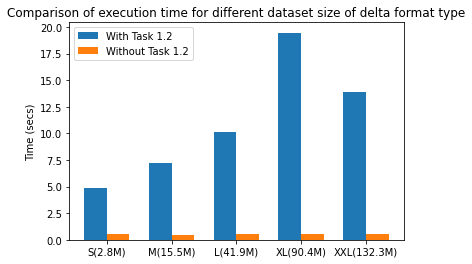

In [ ]:
# Comparison bar graph of execution time for pipeline with and without task 1.2 for different dataset size
N = 5
without12 = (0.50, 0.48, 0.50, 0.50, 0.58)
with12 = (4.87, 7.26, 10.15, 19.46, 13.92)

ind = np.arange(N) 
width = 0.35       
plt.bar(ind, with12, width, label='With Task 1.2')
plt.bar(ind + width, without12, width, label='Without Task 1.2')

plt.ylabel('Time (secs)')
plt.title('Comparison of execution time for different dataset size of delta format type')

plt.xticks(ind + width / 2, ('S(2.8M)', 'M(15.5M)', 'L(41.9M)', 'XL(90.4M)', 'XXL(132.3M)'))
plt.legend(loc='best')
plt.show()

##### 2. Parquet Dataset

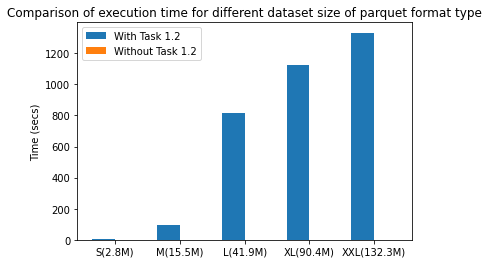

In [ ]:
# Comparison bar graph of execution time for pipeline with and without task 1.2 for different dataset size
N = 5
without12 = (0.50, 0.52, 0.51, 0.51, 0.50)
with12 = (6.58, 93.56, 818.36, 1125.27, 1332.49)

ind = np.arange(N) 
width = 0.35       
plt.bar(ind, with12, width, label='With Task 1.2')
plt.bar(ind + width, without12, width, label='Without Task 1.2')

plt.ylabel('Time (secs)')
plt.title('Comparison of execution time for different dataset size of parquet format type')

plt.xticks(ind + width / 2, ('S(2.8M)', 'M(15.5M)', 'L(41.9M)', 'XL(90.4M)', 'XXL(132.3M)'))
plt.legend(loc='best')
plt.show()

#### Comment

Overall graph of delta and parquet format type of dataset depicts the execution time for the dataset increases with the size of the dataset, as expected. We can also see that the execution time is much higher for the dataset with Task 1.2 than without it, which means that Task 1.2 significantly increases the execution time. This could be due to the increased complexity of the dataset with Task 1.2, which requires additional processing time. Overall, the graph provides useful information about the impact of Task 1.2 on the execution time for different dataset sizes.